In [2]:
import pandas as pd
from pymongo import MongoClient
import json

In [3]:
# https://stackoverflow.com/questions/16249736/how-to-import-data-from-mongodb-to-pandas
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/' % (username, password, host, port)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [4]:
with open("../secrets.json", "r") as f:
    secrets = json.load(f)["DB_SECRETS"]
df = read_mongo('IRI', 'SuicideWatch', host=secrets["DB_HOST"], port=secrets["DB_PORT"], username=secrets["DB_USER"], password=secrets["DB_PASS"])

In [34]:
df

,archived,author,author_flair_css_class,author_flair_text,contest_mode,created_utc,distinguished,domain,edited,gilded,...,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,suggested_sort,thumbnail,title,url
0,False,yeetus131313,None,None,False,1.525136e+09,None,self.SuicideWatch,False,0,...,{},Maybe I should just end it. I don’t have a job...,False,False,SuicideWatch,t5_2qpzs,None,self,Is it time?,https://www.reddit.com/r/SuicideWatch/comments...
1,False,TheSimpleLife56,None,None,False,1.525136e+09,None,self.SuicideWatch,False,0,...,{},I'm done with life. Now I just want to make th...,False,False,SuicideWatch,t5_2qpzs,None,self,How can I make this as easy as possible for my...,https://www.reddit.com/r/SuicideWatch/comments...
2,False,sscorpioszn,None,None,False,1.525137e+09,None,self.SuicideWatch,False,0,...,{},"Hi, I’m kind of nervous so this may be everywh...",False,False,SuicideWatch,t5_2qpzs,None,self,I’m just so tired,https://www.reddit.com/r/SuicideWatch/comments...
3,False,lifejustbounces,None,None,False,1.525138e+09,None,self.SuicideWatch,False,0,...,{},Where do I start? The last 10 years have been ...,False,False,SuicideWatch,t5_2qpzs,None,self,"First stage, alone, vengeful",https://www.reddit.com/r/SuicideWatch/comments...
4,False,getthesegigis,None,None,False,1.525138e+09,None,self.SuicideWatch,False,0,...,{},"I've explained my issues enough to friends, do...",False,False,SuicideWatch,t5_2qpzs,None,self,Burning coal with room sealed tight as I type.,https://www.reddit.com/r/SuicideWatch/comments...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360647,False,LeeChuckThePirate,modmsg,,False,1.577835e+09,None,self.SuicideWatch,False,0,...,{},"The same as last year, drunk and ready to die....",False,False,SuicideWatch,t5_2qpzs,None,self,"I',m starting this new year the same as the ol...",https://www.reddit.com/r/SuicideWatch/comments...
360648,False,pulpheroe,modmsg,,False,1.577836e+09,None,self.SuicideWatch,False,0,...,{},"Oh, i don't know... i don't know \n \nMy fri...",False,False,SuicideWatch,t5_2qpzs,None,self,"I survived 2019, Would i survive 2020?",https://www.reddit.com/r/SuicideWatch/comments...
360649,False,fluffydinofriend,modmsg,,False,1.577836e+09,None,self.SuicideWatch,False,0,...,{},I’ve made a few posts here about me preparing ...,False,False,SuicideWatch,t5_2qpzs,None,self,Thinking about jumping,https://www.reddit.com/r/SuicideWatch/comments...
360650,False,StalkingAnbu,modmsg,,False,1.577837e+09,None,self.SuicideWatch,False,0,...,{},"I am excited and relieved. Just get the gun, w...",False,False,SuicideWatch,t5_2qpzs,None,self,I think this coming year I might actually do it,https://www.reddit.com/r/SuicideWatch/comments...


In [20]:
df.dtypes

archived                   object
author                     object
author_flair_css_class     object
author_flair_text          object
contest_mode                 bool
created_utc               float64
distinguished              object
domain                     object
edited                     object
gilded                      int64
hidden                       bool
id                         object
is_self                      bool
link_flair_css_class       object
link_flair_text            object
locked                       bool
media                      object
media_embed                object
num_comments                int64
over_18                      bool
permalink                  object
score                       int64
secure_media               object
secure_media_embed         object
selftext                   object
spoiler                      bool
stickied                     bool
subreddit                  object
subreddit_id               object
suggested_sort

# Analysis text

In [5]:
import numpy as np
import pandas as pd
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

2023-03-03 18:00:06.059737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
my_stop_words = list(text.ENGLISH_STOP_WORDS.union(["like", "knew", "ll", "we", "ve", "think", "things", "don", "feel", "think", "just", "really", "want", "going", "need", "https", "time", "life", "help", "people", "person", "got", "right", "having", "getting", "does", "didn", "lot", "said", "saying", "do", "make", "getting", "doing", "try", "way", "did", "day", "days", "mental", "health", "im", "feel", "feeling", "felt", "ago", "actually", "doesn", "wouldn", "x200b"]))

In [7]:
vectorizer = TfidfVectorizer(max_features=300, strip_accents="unicode", stop_words=my_stop_words)
vector = vectorizer.fit_transform(df["selftext"])
df['tfidf'] = list(vector.toarray())

In [9]:
df_text = df[["created_utc","tfidf"]]
df_text['date'] = pd.to_datetime(df['created_utc'], unit='s')

# group by month summing up the tfidf column
df_tf = pd.DataFrame([{x: y for x, y in enumerate(item)} for item in df_text['tfidf'].values.tolist()], index=df_text.index)
df_tf["date"]=df_text["date"]#.columns = ['tfidf_{}'.format(str(x+1)) for x in df_tf.columns]

# group by month summing up the tfidf column
df_group = df_tf.groupby(pd.Grouper(key='date', freq='M')).sum()
df_group.columns = vectorizer.get_feature_names_out()

/tmp/ipykernel_2749686/3508709020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['date'] = pd.to_datetime(df['created_utc'], unit='s')


Generate WordClouds per month

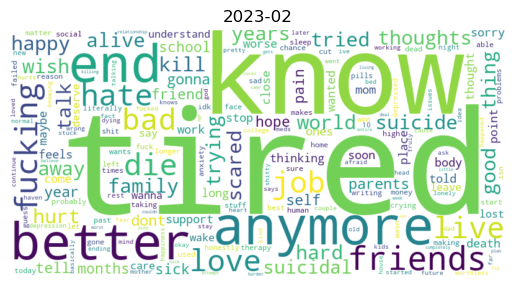

In [50]:
for row in df_group.iterrows():
    month = row[0].strftime("%Y-%m")
    text_dict = row[1].to_dict()
    wc = WordCloud(width=800, height=400, background_color="white", random_state=1).generate_from_frequencies(text_dict)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(month)
    plt.savefig("wordclouds/wordcloud_{}.png".format(month))


Create GIF from wordcloud images

In [52]:
from PIL import Image
import glob

# Create a list of frames
frames = []
imgs = glob.glob("wordclouds/*.png") # get all png images in current folder
imgs.sort()

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save as a GIF file
frames[0].save('png_to_gif.gif', format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)


Generate interactive bar plot for word tfidf

In [10]:
# convert df_group:
# all columns to a single column named "word"
# all rows to a single column named "count"
# date index to a single column named "date"
df_group_transpose = df_group.stack().reset_index(name='count')
df_group_transpose.columns = ['date', 'word', 'count']
df_group_transpose['date'] = df_group_transpose['date'].dt.strftime('%Y-%m')

In [27]:
import plotly.express as px
# use plotly express create bar chart of df_group, height is value of each column, animated by month
fig = px.bar(df_group_transpose, x="word", y="count", animation_frame="date", animation_group="word", range_y=[0, 500])
fig.update_xaxes(visible=False)
fig.update_layout(width=800, height=600)
fig.show()

In [29]:
fig.write_html("wordhist.html")

In [24]:
from raceplotly.plots import barplot
fig = barplot(df_group_transpose, item_column="word", value_column="count", time_column="date", top_entries=10)
fg = fig.plot(item_label = 'Top 10 words', value_label = 'TF-IDF Frequency', frame_duration = 800)
fg.update_layout(width=800, height=600)

In [30]:
fg.write_html("wordtop10.html")

In [18]:
import plotly
plotly.io.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

# Analysis unique user time zone

In [25]:
# for each unique user get all created_utc
df_time = df.groupby('author').agg({'created_utc': list})

In [29]:
# show author with more than 1 post
df_time[df_time['created_utc'].apply(lambda x: len(x) > 1)]

,created_utc
author,
-------RS--------,"[1568077973.0, 1568154170.0]"
---Bubbles---,"[1655591856.0, 1631310298.0, 1632078580.0]"
---jordan---,"[1671415351.0, 1672106653.0, 1671415351.0, 158..."
---kali---,"[1604449000.0, 1588838023.0]"
---t-r-a-s-h---,"[1657582015.0, 1661295451.0, 1665007242.0]"
...,...
zzcool,"[1597554671.0, 1620954813.0, 1602909382.0]"
zzmat,"[1560484757.0, 1598338678.0]"
zzprepro,"[1541199664.0, 1541379293.0]"
